In [1]:
##########################################
#  STEP 1. IMPORTS & GLOBAL CONFIG       #
##########################################
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pickle 
import speech_recognition as sr
from transformers import BertTokenizer, BertModel, TFBertModel
import torch
import tensorflow_hub as hub

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/Users/shreyanandini/Desktop/Stress Level Detection From Speech/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shreyanandini/Desktop/Stress Level Detection From Speech/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Directory where your data is located (adjust as needed)
BASE_DIR = r"/Users/shreyanandini/Desktop/Stress Level Detection From Speech/Audio_Speech_Actors_01-24"
total_files = sum(len(files) for _, _, files in os.walk(BASE_DIR))

print(f"Total number of files: {total_files}")

Total number of files: 1421


In [ ]:
# ##########################################
# #  STEP 2. DATA LOADING & LABELING       #
# ##########################################
# # We create a DataFrame to store metadata
# data_df = pd.DataFrame(columns=['file_path', 'src', 'actor', 'gender', 'intensity', 'statement', 'repeat', 'emotion','transcript'])

# # Check if the base directory exists
# if not os.path.isdir(BASE_DIR):
#     raise ValueError(f"BASE_DIR does not exist: {BASE_DIR}")

# dir_list = os.listdir(BASE_DIR)
# dir_list.sort()
# count = 0
# recognizer = sr.Recognizer()


# for folder in dir_list:
#     folder_path = os.path.join(BASE_DIR, folder)
#     transcript = ""
#     # If it's not a directory, skip
#     if not os.path.isdir(folder_path):
#         continue
#     for f in os.listdir(folder_path):
#         if not f.endswith('.wav'):
#             continue      
#         # Example filename pattern: "03-01-01-01-01-01-01.wav"
#         nm = f.split('.')[0].split('-')         
#         #try:
#         emotion = int(nm[2])   
#         src = int(nm[1])
#         actor = int(nm[-1])
#         emotion = int(nm[2])
        
#         if int(actor)%2 == 0:
#             gender = "female"
#         else:
#             gender = "male"
        
#         if nm[3] == '01':
#             intensity = 0
#         else:
#             intensity = 1
        
#         if nm[4] == '01':
#             statement = 0
#         else:
#             statement = 1
        
#         if nm[5] == '01':
#             repeat = 0
#         else:
#             repeat = 1
#         file_path = os.path.join(folder_path, f)
#         try:
#             with sr.AudioFile(file_path) as source:
#                 data = recognizer.record(source)
#                 transcript = recognizer.recognize_google(data, key=None)
#             #print("Transcript:", transcript)
#         except Exception as e:
#             print("Error during transcription:", e)
#             transcript = "Could not process audio transcription."
#             # except (IndexError, ValueError) as e:
#             #     print(f"Skipping file (naming mismatch): {f}")
#             #     continue
#             #print(file_path)
#             #Ensuring the .wav file exists
#         if os.path.isfile(file_path):
#             data_df.loc[count] = [file_path, src, actor, gender, intensity, statement, repeat, emotion,transcript]
#             count += 1
#         else:
#             print(f"File not found: {file_path}")

In [2]:
#data_df.to_csv("audio_to_transcript.csv")
data_df = pd.read_csv("/Users/shreyanandini/Desktop/Stress Level Detection From Speech/audio_to_transcript.csv")

In [ ]:
# for i in range(len(data_df)):
#     if data_df.emotion[i] == 1:
#         lb = "_neutral"
#     elif data_df.emotion[i] == 2:
#         lb = "_calm"
#     elif data_df.emotion[i] == 3:
#         lb = "_happy"
#     elif data_df.emotion[i] == 4:
#         lb = "_sad"
#     elif data_df.emotion[i] == 5:
#         lb = "_angry"
#     elif data_df.emotion[i] == 6:
#         lb = "_fearful"
#     elif data_df.emotion[i] == 7:
#         lb = "_disgust"
#     elif data_df.emotion[i] == 8:
#         lb = "_surprised"

In [3]:
def map_emotion_to_stress(e):
    """
    In your dataset, 4/6 = high stress -> 2, 
                     5/7 = low stress -> 1,
                    else 0 = no stress
    """
    if e in [4,6]:
        return 2
    elif e in [5,7]:
        return 1
    else:
        return 0

data_df['stress_label'] = data_df['emotion'].apply(map_emotion_to_stress)

print(data_df.head())
print("Total files:", len(data_df))

# Shuffle dataframe
data_df = data_df.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

   Unnamed: 0.1  Unnamed: 0  \
0             0          51   
1             1         289   
2             2         677   
3             3        1005   
4             4         367   

                                           file_path  src  actor  gender  \
0  /Users/shreyanandini/Desktop/Stress Level Dete...    1      1    male   
1  /Users/shreyanandini/Desktop/Stress Level Dete...    1      5    male   
2  /Users/shreyanandini/Desktop/Stress Level Dete...    1     12  female   
3  /Users/shreyanandini/Desktop/Stress Level Dete...    1     18  female   
4  /Users/shreyanandini/Desktop/Stress Level Dete...    1      7    male   

   intensity  statement  repeat  emotion                    transcript  \
0          1          1       1        6  dogs are sitting by the door   
1          0          0       1        1  kids are talking by the door   
2          0          0       0        4  kids are talking by the door   
3          0          0       1        6   can you talking b

In [4]:
##########################################
#  STEP 3. TRAIN/VAL/TEST SPLIT          #
##########################################
# Splitting data_df into Training and Temporary Sets(temp_df)
train_df, temp_df = train_test_split(
    data_df,
    test_size=0.2,
    stratify=data_df['stress_label'],
    random_state=RANDOM_SEED
)
# Splitting the Temporary Set into Validation and Test Sets
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['stress_label'],
    random_state=RANDOM_SEED
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 1136, Val size: 142, Test size: 142


In [5]:
##########################################
#  STEP 4. FEATURE EXTRACTION (MFCC)     #
##########################################
SAMPLE_RATE = 16000       # or 22050
MAX_DURATION_SEC = 120.0    # we’ll pad/truncate to 5s
N_MFCC = 40
FIXED_FRAMES = 200        # number of frames along time axis
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def load_audio(file_path, sr=SAMPLE_RATE, max_duration=MAX_DURATION_SEC):
    # Load up to max_duration seconds
    y, sr = librosa.load(file_path, sr=sr, duration=max_duration)
    return y, sr

def extract_mfcc(file_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    y, sr = load_audio(file_path, sr=sr, max_duration=MAX_DURATION_SEC)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape: (n_mfcc, time_frames)
    # Pad or truncate to FIXED_FRAMES along the time axis
    if mfcc.shape[1] < FIXED_FRAMES:
        pad_width = FIXED_FRAMES - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0), (0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :FIXED_FRAMES]
   
    return mfcc
def extract_bert_embedding(text):
    if not text or text == "Could not process audio transcription.":
        return np.zeros((768,))
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

def build_features_and_labels(df):
    X_audio_list, X_text_list, y_list = [], [], []
    for _, row in df.iterrows():
        file_path = row['file_path']
        transcript = row['transcript']
        label = row['stress_label']

        if not os.path.isfile(file_path):
            continue

        mfcc = extract_mfcc(file_path)
        mfcc = np.expand_dims(mfcc, axis=-1)
        bert_embedding = extract_bert_embedding(transcript)

        X_audio_list.append(mfcc)
        X_text_list.append(bert_embedding)
        y_list.append(label)

    X_audio_arr = np.array(X_audio_list, dtype=np.float32)
    X_text_arr = np.array(X_text_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.int64)

    return X_audio_arr, X_text_arr, y_arr

X_train_audio, X_train_text, y_train = build_features_and_labels(train_df)
X_val_audio, X_val_text, y_val = build_features_and_labels(val_df)
X_test_audio, X_test_text, y_test = build_features_and_labels(test_df)

In [ ]:
##########################################
#  STEP 5. BUILD THE CNN MODEL           #
##########################################
# num_classes = 3  # no-stress, low-stress, high-stress
# model = models.Sequential([
#     layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',
#                   input_shape=(N_MFCC, FIXED_FRAMES, 1)),
#     layers.MaxPooling2D(pool_size=(2,2)),
   
#     layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
   
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_classes, activation='softmax')
# ])
# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [6]:
##########################################
#  STEP 5. BUILD THE CNN MODEL           #
##########################################
num_classes = 3
audio_input = Input(shape=(N_MFCC, FIXED_FRAMES, 1), name="audio_input")
audio_model = layers.Conv2D(16, (3, 3), activation='relu')(audio_input)
audio_model = layers.MaxPooling2D((2, 2))(audio_model)
audio_model = layers.Conv2D(32, (3, 3), activation='relu')(audio_model)
audio_model = layers.MaxPooling2D((2, 2))(audio_model)
audio_model = layers.Flatten()(audio_model)

text_input = Input(shape=(768,), name="text_input")
text_model = layers.Dense(128, activation='relu')(text_input)
text_model = layers.Dropout(0.3)(text_model)

fusion = layers.Concatenate()([audio_model, text_model])
fusion = layers.Dense(64, activation='relu')(fusion)
fusion = layers.Dropout(0.3)(fusion)
output = layers.Dense(num_classes, activation='softmax')(fusion)

model = models.Model(inputs=[audio_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 40, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 198,   │        160 │ audio_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 99,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 17, 97,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 48, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     98,432 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12288)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12416)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    794,688 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 898,115 (3.43 MB)

 Trainable params: 898,115 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
num_classes = 3
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [8]:
##########################################
#  STEP 6. TRAIN THE MODEL               #
##########################################
EPOCHS = 50     # adjust as needed
BATCH_SIZE = 32

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor (e.g., validation loss)
    patience=5,              # Number of epochs to wait before stopping
    restore_best_weights=True # Restore the best weights
)

# Train the model with early stopping
history = model.fit(
    [X_train_audio, X_train_text], y_train_one_hot,
    validation_data=([X_val_audio, X_val_text], y_val_one_hot),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]  # Add the early stopping callback here
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3734 - loss: 19.8580 - val_accuracy: 0.5070 - val_loss: 1.0390
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4721 - loss: 1.0057 - val_accuracy: 0.5141 - val_loss: 1.0107
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5005 - loss: 0.9605 - val_accuracy: 0.5282 - val_loss: 0.9905
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5166 - loss: 0.9257 - val_accuracy: 0.4718 - val_loss: 0.9935
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5310 - loss: 0.8845 - val_accuracy: 0.5423 - val_loss: 0.9214
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5651 - loss: 0.8580 - val_accuracy: 0.5423 - val_loss: 0.9804
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5991 - loss: 0.7805 - val_accuracy: 0.5775 - val_loss: 0.8903
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6338 - loss: 0.7078 - val_accuracy: 0.5704 - 

In [9]:
##########################################
#  STEP 7. EVALUATION & METRICS          #
##########################################
test_loss, test_acc = model.evaluate([X_test_audio, X_test_text], y_test_one_hot, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

y_pred_proba = model.predict([X_test_audio, X_test_text])
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Stress', 'Low Stress','High Stress']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Loss: 0.8599 | Test Accuracy: 0.6479
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:
              precision    recall  f1-score   support

   No Stress       0.63      0.75      0.68        67
  Low Stress       0.69      0.68      0.68        37
 High Stress       0.63      0.45      0.52        38

    accuracy                           0.65       142
   macro avg       0.65      0.62      0.63       142
weighted avg       0.65      0.65      0.64       142

Confusion Matrix:
[[50  9  8]
 [10 25  2]
 [19  2 17]]


In [10]:
# ---------------------------
# 7. Evaluate
# ---------------------------
loss, acc = model.evaluate([X_test_audio, X_test_text], y_test_one_hot, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc*100:.2f}%")


Test Loss: 0.8599, Test Accuracy: 64.79%


In [11]:
# Flatten MFCC for SVM and Random Forest
def prepare_flat_features(X_audio, X_text):
    X_audio_flat = X_audio.reshape(X_audio.shape[0], -1)  # Flatten MFCC
    X_combined = np.concatenate((X_audio_flat, X_text), axis=1)  # Combine audio and text features
    return X_combined

# Prepare train, validation, and test data
X_train_combined = prepare_flat_features(X_train_audio, X_train_text)
X_val_combined = prepare_flat_features(X_val_audio, X_val_text)
X_test_combined = prepare_flat_features(X_test_audio, X_test_text)

# Train and evaluate SVM
print("Training SVM...")
svm_model = SVC(kernel='rbf', C=1.0, random_state=RANDOM_SEED)
svm_model.fit(X_train_combined, y_train)

print("Evaluating SVM...")
y_pred_svm = svm_model.predict(X_test_combined)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"SVM F1 Score: {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")

# Train and evaluate Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_model.fit(X_train_combined, y_train)

print("Evaluating Random Forest...")
y_pred_rf = rf_model.predict(X_test_combined)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")


Training SVM...
Evaluating SVM...
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.99      0.72        67
           1       0.79      0.51      0.62        37
           2       1.00      0.03      0.05        38

    accuracy                           0.61       142
   macro avg       0.79      0.51      0.46       142
weighted avg       0.74      0.61      0.51       142

SVM Confusion Matrix:
[[66  1  0]
 [18 19  0]
 [33  4  1]]
SVM Accuracy: 0.6056
SVM F1 Score: 0.5145
Training Random Forest...
Evaluating Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        67
           1       0.73      0.65      0.69        37
           2       0.62      0.21      0.31        38

    accuracy                           0.65       142
   macro avg       0.66      0.59      0.58       142
weighted avg       0.65      0.65      0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


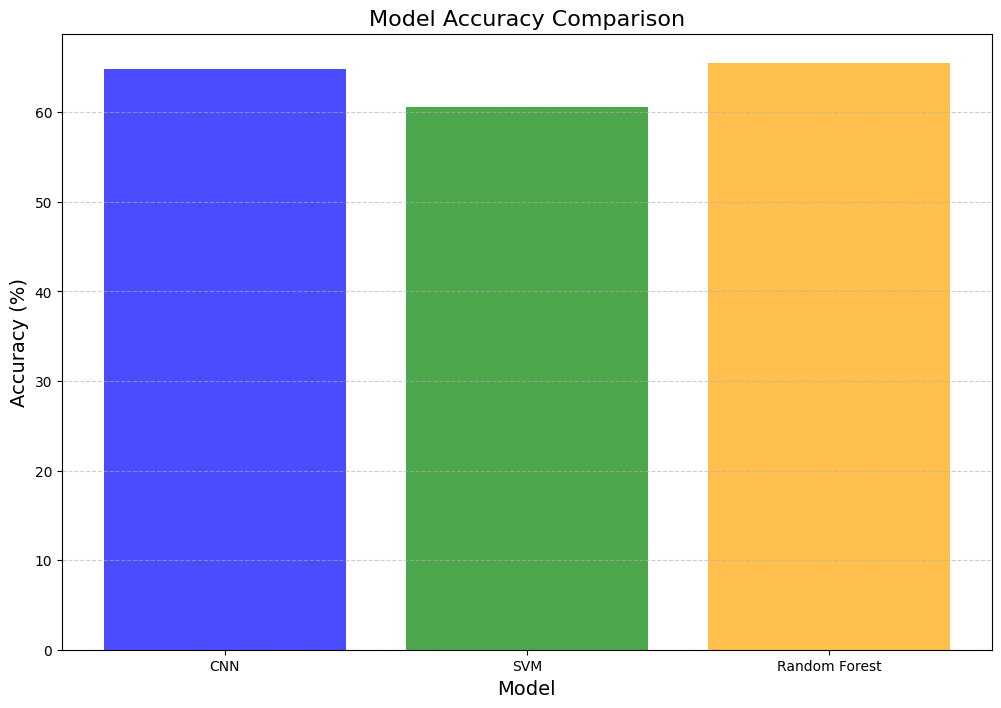

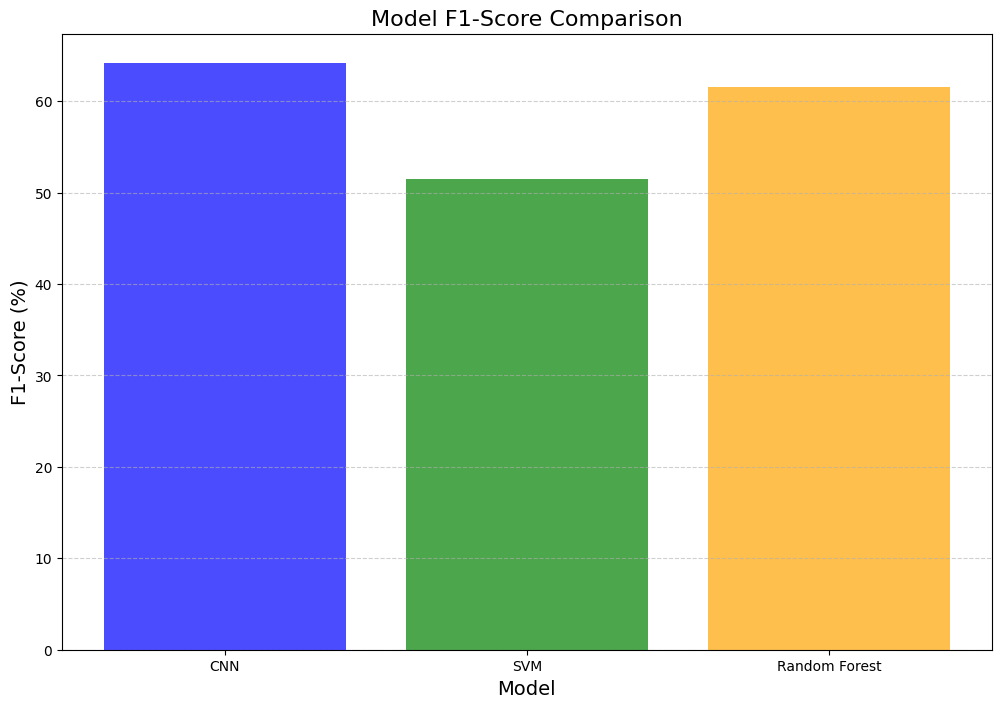

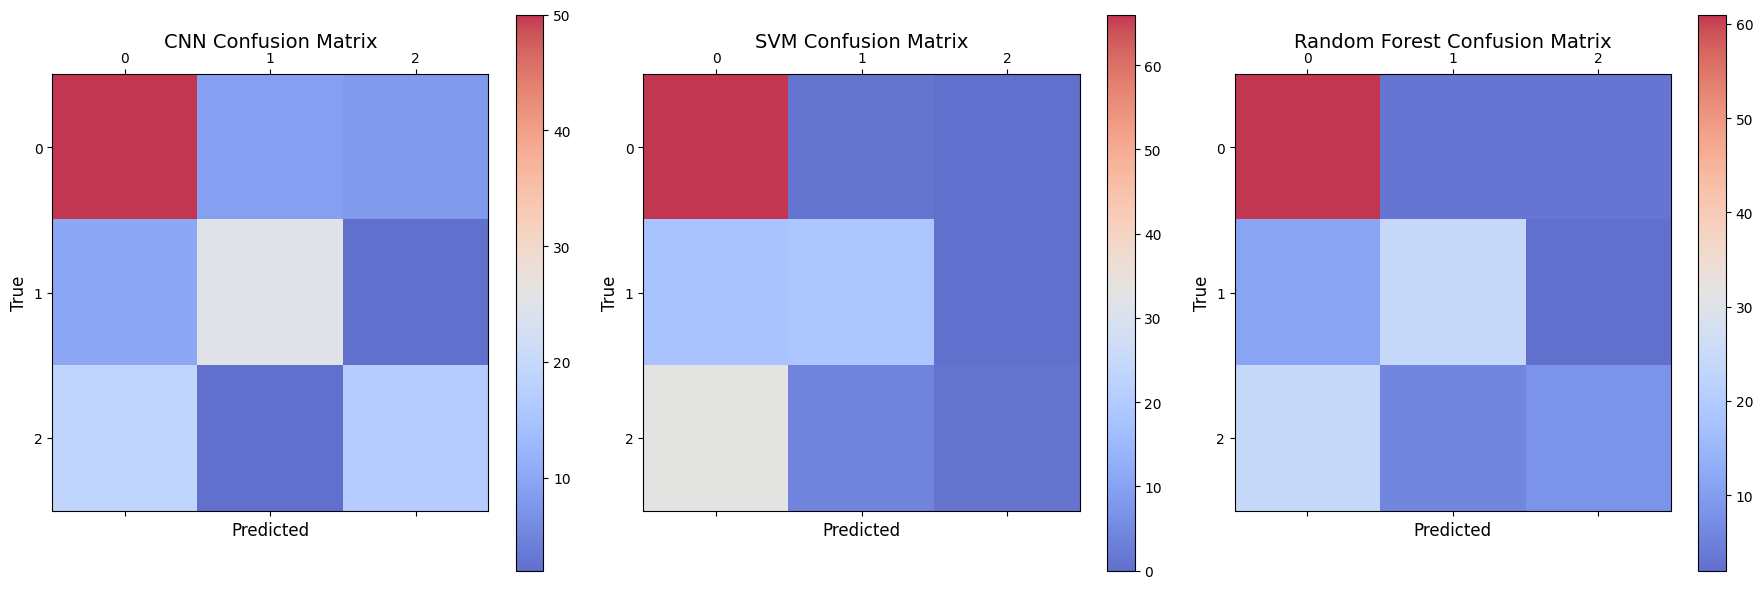

In [12]:
# Rerunning the evaluation and plotting
cnn_predictions = np.argmax(model.predict([X_test_audio, X_test_text]), axis=1)

# Recalculating metrics for CNN
cnn_accuracy = accuracy_score(y_test, cnn_predictions) * 100
cnn_f1_score = f1_score(y_test, cnn_predictions, average='weighted') * 100
cnn_conf_matrix = confusion_matrix(y_test, cnn_predictions)

# SVM and Random Forest metrics are already available
svm_accuracy = accuracy_score(y_test, y_pred_svm) * 100
svm_f1_score = f1_score(y_test, y_pred_svm, average='weighted') * 100
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)

rf_accuracy = accuracy_score(y_test, y_pred_rf) * 100
rf_f1_score = f1_score(y_test, y_pred_rf, average='weighted') * 100
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Data for plotting
models = ['CNN', 'SVM', 'Random Forest']
accuracy = [cnn_accuracy, svm_accuracy, rf_accuracy]
f1_scores = [cnn_f1_score, svm_f1_score, rf_f1_score]
conf_matrices = [cnn_conf_matrix, svm_conf_matrix, rf_conf_matrix]

# Plot 1: Accuracy comparison
plt.figure(figsize=(12, 8))
plt.bar(models, accuracy, color=['blue', 'green', 'orange'], alpha=0.7)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Plot 2: F1-Score comparison
plt.figure(figsize=(12, 8))
plt.bar(models, f1_scores, color=['blue', 'green', 'orange'], alpha=0.7)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1-Score (%)', fontsize=14)
plt.title('Model F1-Score Comparison', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Plot 3: Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['CNN Confusion Matrix', 'SVM Confusion Matrix', 'Random Forest Confusion Matrix']
for i, ax in enumerate(axes):
    cax = ax.matshow(conf_matrices[i], cmap='coolwarm', alpha=0.8)
    fig.colorbar(cax, ax=ax)
    ax.set_title(titles[i], pad=20, fontsize=14)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
plt.tight_layout()
plt.show()


In [14]:
##########################################
#  STEP 8. SAVE THE MODEL                #
##########################################
model.save("stress_detector_cnn.h5")
print("Model saved as stress_detector_cnn.h5")
# Optionally, you can also do:
# joblib.dump(model, "stress_detector_cnn.pkl") 

pickle.dump(model,open('model.pkl','wb'))

Model saved as stress_detector_cnn.h5
